In [2]:
# imports
from scipy.special import erf
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# constants
height = 75 * 10**-6 # meters
width = 500 * 10**-6 # meters
flow_rate = (25 * 10**-9) / 60 # m^3 per second from microliters per minute

temp = 293 # kelvin, 20 degrees in lab
viscocity = 10**-3 #viscocity 
k_b = 1.38 * 10**-23 # boltzmann constant


# Length from start of diffusion (m)
l1 = 789 * 10**-6 
l2 = 1360 * 10**-6 
l3 = 1838 * 10**-6 
l4 = 2468 * 10**-6 

In [4]:
# Calculate velocity of water
cross_section = height * width #m^2
velocity = flow_rate / cross_section #m/s
print(velocity)
# Calculate time to reach each point (s)
t1 = l1 / velocity
t2 = l2 / velocity
t3 = l3 / velocity
t4 = l4 / velocity
print(t1, t2, t3, t4)

0.011111111111111113
0.07100999999999999 0.12239999999999997 0.16541999999999996 0.22211999999999993


In [5]:
#import data
line1 = pd.read_csv('./line_1.csv')
line2 = pd.read_csv('./line_2.csv')
line3 = pd.read_csv('./line_3.csv')
line4 = pd.read_csv('./line_4.csv')

In [6]:
# Get x values and y values
x1, y1 = line1.values.T
x2, y2 = line2.values.T
x3, y3 = line3.values.T
x4, y4 = line4.values.T


In [7]:
#Helper functions

# Normalisation
def normalize(val):
    max_val = sum(val[1:100])/len(val[1:100])  # Averaging the first 100 data points
    min_val = sum(val[-100:])/len(val[-100:])  # Averaging the last 100 data points
    return [(i - min_val)/(max_val - min_val) for i in val]

# Absorbance
def absorbance(I_max, I):
    return np.log10(I_max/I)

# Radius from Stokes-Einstein equation
def stokes_einstein(D):
    return k_b * temp / (6 * np.pi * viscocity * D)

In [8]:
# ficks law for each line, because of curve_fit

def ficks1(x, x_0, D):
    return 0.5*(1-erf((x-x_0)/(2*np.sqrt(abs(D*t1)))))

def ficks2(x, x_0, D):
    return 0.5*(1-erf((x-x_0)/(2*np.sqrt(abs(D*t2)))))

def ficks3(x, x_0, D):
    return 0.5*(1-erf((x-x_0)/(2*np.sqrt(abs(D*t3)))))

def ficks4(x, x_0, D):
    return 0.5*(1-erf((x - x_0)/np.sqrt(4*D*t4)))

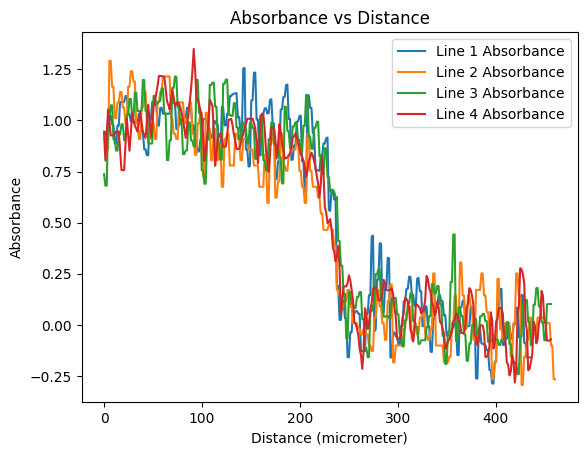

In [9]:
#Avg max value 
y1_max = sum(y1[1:100])/len(y1[1:100])
y2_max = sum(y2[1:100])/len(y2[1:100])
y3_max = sum(y3[1:100])/len(y3[1:100])
y4_max = sum(y4[1:100])/len(y4[1:100])

# Absorbance
y1_abs = [absorbance(y1_max, val) for val in y1]
y2_abs = [absorbance(y2_max, val) for val in y2]
y3_abs = [absorbance(y3_max, val) for val in y3]
y4_abs = [absorbance(y4_max, val) for val in y4]

# Normalize
y1_n = normalize(y1_abs)
y2_n = normalize(y2_abs)
y3_n = normalize(y3_abs)
y4_n = normalize(y4_abs)

# Plot absorbance values

plt.plot(x1, y1_n, label='Line 1 Absorbance')
plt.plot(x2, y2_n, label='Line 2 Absorbance')
plt.plot(x3, y3_n, label='Line 3 Absorbance')
plt.plot(x4, y4_n, label='Line 4 Absorbance')
plt.xlabel('Distance (micrometer)')
plt.ylabel('Absorbance')
plt.title('Absorbance vs Distance')
plt.legend()
plt.show()

In [10]:
# Fitted curves
params1, cov1 = curve_fit(ficks1, x1, y1_n)
params2, cov2 = curve_fit(ficks2, x2, y2_n)
params3, cov3 = curve_fit(ficks3, x3, y3_n)
params4, cov4 = curve_fit(ficks4, x4, y4_n)  
# cov gives nothing of use, so we ignore it

# Convert D to m^2/s
D_1 = params1[0] * 10**-12
D_2 = params2[0] * 10**-12
D_3 = params3[0] * 10**-12
D_4 = params4[0] * 10**-12
D_list = [D_1, D_2, D_3, D_4]
D_avg = (D_1 + D_2 + D_3 + D_4) / 4
D_std = np.std(D_list)
print("Diffusion constant", D_avg, ", standard deviation", D_std)
#Particle radius
r1 = stokes_einstein(D_1)
r2 = stokes_einstein(D_2)
r3 = stokes_einstein(D_3)
r4 = stokes_einstein(D_4)
r_list = [r1, r2, r3, r4]
r_avg = (r1 + r2 + r3 + r4) / 4
r_std = np.std(r_list)
print("radius according to stokes einstein", r_avg, "meters, standard deviation", r_std)

Diffusion constant 2.292481509980266e-10 , standard deviation 6.757113862422119e-12
radius according to stokes einstein 9.365333907684203e-10 meters, standard deviation 2.8052826388858435e-11


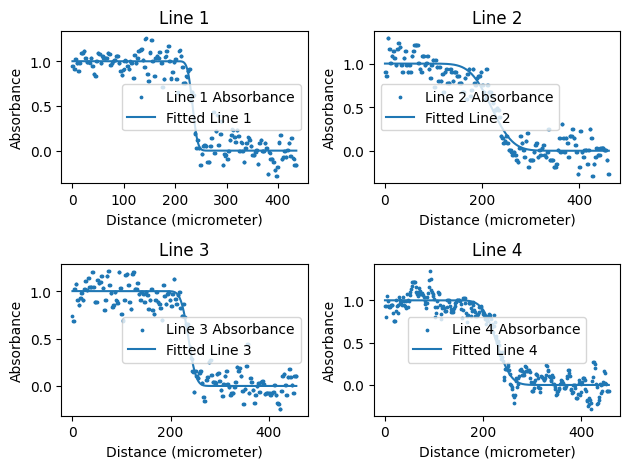

In [11]:
# Lines
fig, ax = plt.subplots(2,2)
ax[0,0].scatter(x1, y1_n, label='Line 1 Absorbance', s=3)
ax[0,0].plot(x1, ficks1(x1, *params1), label='Fitted Line 1')
ax[0,0].set_title('Line 1')
ax[0,0].set_xlabel('Distance (micrometer)')
ax[0,0].set_ylabel('Absorbance')
ax[0,0].legend()

ax[0,1].scatter(x2, y2_n, label='Line 2 Absorbance', s=3)
ax[0,1].plot(x2, ficks2(x2, *params2), label='Fitted Line 2')
ax[0,1].set_title('Line 2')
ax[0,1].set_xlabel('Distance (micrometer)')
ax[0,1].set_ylabel('Absorbance')
ax[0,1].legend()

ax[1,0].scatter(x3, y3_n, label='Line 3 Absorbance', s=3)
ax[1,0].plot(x3, ficks3(x3, *params3), label='Fitted Line 3')
ax[1,0].set_title('Line 3')
ax[1,0].set_xlabel('Distance (micrometer)')
ax[1,0].set_ylabel('Absorbance')
ax[1,0].legend()

ax[1,1].scatter(x4, y4_n, label='Line 4 Absorbance', s=3)
ax[1,1].plot(x4, ficks4(x4, *params4), label='Fitted Line 4')
ax[1,1].set_title('Line 4')
ax[1,1].set_xlabel('Distance (micrometer)')
ax[1,1].set_ylabel('Absorbance')
ax[1,1].legend()

plt.tight_layout()
plt.show()



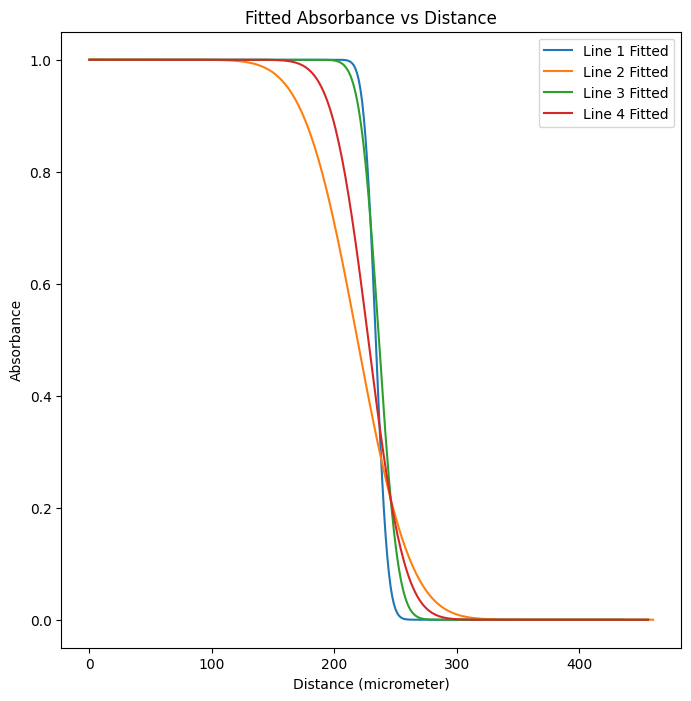

In [13]:
# Plot fitted curves 
plt.plot(x1, ficks1(x1, *params1), label='Line 1 Fitted')
plt.plot(x2, ficks2(x2, *params2), label='Line 2 Fitted')
plt.plot(x3, ficks3(x3, *params3), label='Line 3 Fitted')
plt.plot(x4, ficks4(x4, *params4), label='Line 4 Fitted')
plt.rcParams["figure.figsize"] = (8,8)
plt.xlabel('Distance (micrometer)')
plt.ylabel('Absorbance')
plt.title('Fitted Absorbance vs Distance')
plt.legend()
plt.show()